In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

train = pd.read_csv('data/iowa_housing/train.csv')
test = pd.read_csv('data/iowa_housing/test.csv')
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

#linear model - 

#random forest:
#foundation categorical, 

def rmse(model,X,y):
    preds = model.predict(X)
    error = np.sqrt(np.mean(preds - y)**2)
    return error

In [2]:
#create columns that arent saleprice
x_cols = train.columns[train.columns != 'saleprice']
#create numeric column list
numeric_cols = list(train.select_dtypes(include=[np.number]))

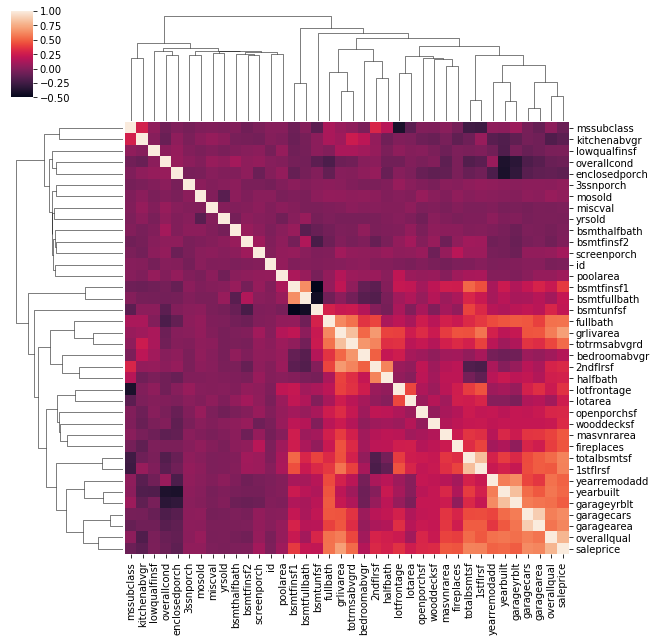

In [3]:
sns.clustermap(train[numeric_cols].corr())
#looked at cluster map to get an idea of correlations

In [4]:
#create a list of numeric columns that have an absolute correlation > 0.35 with sale price
cols_with_corr = list(abs(train[numeric_cols].corr()['saleprice'] > 0.35))


In [62]:
#for loop to find the columns with correlation and make a list of them
count = 0
cols_with_corr1 = []
for i in numeric_cols:
    if cols_with_corr[count]:
        cols_with_corr1.append(i)
        count+=1
    else:
        count+=1
        next
#remove sale price from columns
cols_with_corr1.pop()

'saleprice'

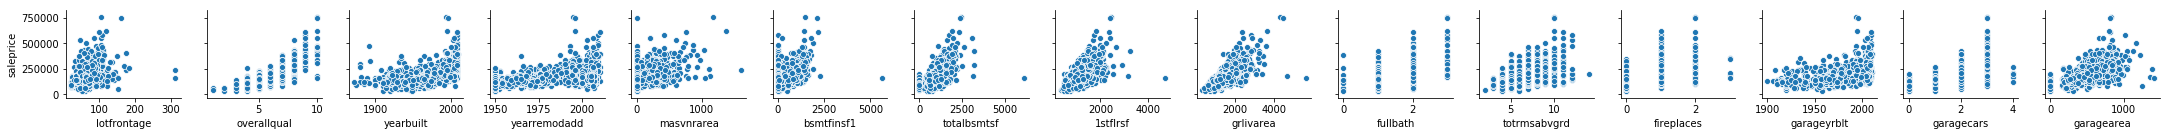

In [257]:
sns.pairplot(train,x_vars=cols_with_corr1,y_vars='saleprice',height=2,aspect=1)
#wanted to look at scatter plots

In [63]:
#import cross val and define lreg
from sklearn.model_selection import cross_val_score
lreg = LinearRegression()

In [64]:
#build X and Y for linear regression model
X = train.loc[:,cols_with_corr1]
y = np.log1p(train['saleprice'])
#remove NA from my X
na_map = X.mean()
#fill X na with their avg values
X.fillna(na_map,inplace=True)

lreg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [65]:
scores = cross_val_score(estimator=lreg, X=X, y=y, scoring=rmse, cv=10)

In [66]:
scores


array([0.00024419, 0.0221049 , 0.00689599, 0.01311078, 0.00492835,
       0.02570932, 0.00688401, 0.0109592 , 0.00363428, 0.01608526])

In [67]:
#run linear regression for 1/2 of my model, next steps are to test how this prediction worked and then start buildilng in the random forst for the ategorical data.

X_test = test.loc[:,cols_with_corr1]
X_test.fillna(na_map,inplace=True)
lreg.predict(X_test)

array([11.65337985, 11.84845851, 12.06850692, ..., 12.05102346,
       11.6749032 , 12.41656858])

In [68]:
test['prediction'] = lreg.predict(X_test)


In [70]:
output = pd.DataFrame({
    'Id'       : np.arange(1461, 2920),
    'SalePrice': np.exp(test.prediction)
})

In [408]:

output.to_csv('data/iowa_housing/sample_predictions.csv', index=False)

#this test did slightly better than initial class one.

**Below here is where we begin setting up a 2nd test, i am going to combine an equal weight of 50% linear reg and 50% random forest**

In [7]:
#random forest test/train
other_cols = [i for i in range(1,81) if i not in [1, 17, 18, 19, 43, 44, 46, 49, 50, 70, 77,]]
train2 = pd.read_csv('data/iowa_housing/train.csv', usecols=other_cols)
test2  = pd.read_csv('data/iowa_housing/test.csv', usecols=other_cols[:-1])

#get columns i didnt use before

In [4]:
train2[train2['PoolQC'].isna() == False]['SalePrice'].mean(), train2[train2['PoolQC'].isna()]['SalePrice'].mean() #check diff between pool and no pool

(288138.5714285714, 180404.66345492084)

In [8]:
train2['PoolQC'] = np.where(train2['PoolQC'].isna(),0,1)
test2['PoolQC'] = np.where(test2['PoolQC'].isna(),0,1)
#trying to encode 0 or 1 - if it is a str 1 or if it is nan 0 

In [9]:
train2['CentralAir'] = np.where(train2['CentralAir'] == 'Y',1,0)
test2['CentralAir'] = np.where(test2['CentralAir'] == 'Y',1,0)
#more 1/0 enconding

In [10]:
train2['PavedDrive'] = np.where(train2['PavedDrive'] == 'Y',1,0)
test2['PavedDrive'] = np.where(test2['PavedDrive'] == 'Y',1,0)
#more 1/0 encoding

In [20]:
neighborhood_map = train2.groupby('Neighborhood')['SalePrice'].median()
train2['Neighborhood_2'] = train2['Neighborhood'].map(neighborhood_map)
test2['Neighborhood_2'] = test2['Neighborhood'].map(neighborhood_map)
#target encode neighborhood

In [21]:
train2.head()

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,Neighborhood_2
0,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,NaN,NaN,0,2,WD,Normal,208500,197200
1,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,NaN,NaN,0,5,WD,Normal,181500,218000
2,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,NaN,NaN,0,9,WD,Normal,223500,197200
3,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,NaN,NaN,0,2,WD,Abnorml,140000,200624
4,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,NaN,NaN,0,12,WD,Normal,250000,301500


In [63]:
X_t2 = train2.columns[train2.columns != 'SalePrice'].tolist()
 #make a list of clolumns that arent sale price

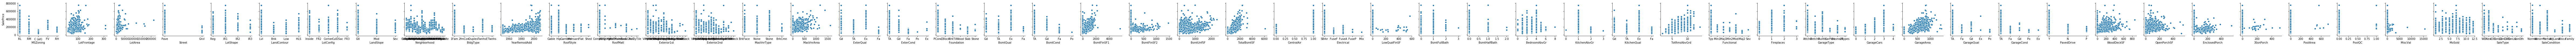

In [64]:
sns.pairplot(train2,x_vars=X_t2,y_vars='SalePrice')
#look at some relationships

In [41]:
#this dropped the columns that were mostly NA or i didn't want to use
drop_columns = ['MiscFeature','Alley','Utilities','Fence','FireplaceQu','GarageYrBlt','GarageFinish','BsmtExposure',
                'Condition1','Condition2','HouseStyle','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC',
                'Street']
test2 = test2.drop(drop_columns,axis=1)
train2 = train2.drop(drop_columns,axis=1)

In [42]:
df1 = (test2.isnull().sum() > 0).to_frame('NA_cols')
test_na_cols = df1.index[df1['NA_cols'] == True].tolist()
#df1 becomes the columns w NA in test, and test_na_cols is the list of cols in test with na
df2 = (train2.isnull().sum()>0).to_frame('NA_cols')
na_cols2 = df2.index[df2['NA_cols'] == True].tolist()
#df2 becomes columns w NA in train, finding all the columns w NA to replace their stuff w the mode

In [43]:
#cleaning data and filling columns
train2['LotFrontage'].fillna(train2.LotFrontage.median(),inplace=True)
test2['LotFrontage'].fillna(train2.LotFrontage.median(),inplace=True)
train2['MasVnrArea'].fillna(train2.MasVnrArea.median(),inplace=True)



In [44]:
#gather all the NA columns in the test and organizee them by numerical or categorical columns
test2_num_na_cols = ['MasVnrArea',
                     'BsmtFinSF1',
                     'BsmtFinSF2',
                     'BsmtUnfSF',
                     'TotalBsmtSF',
                     'BsmtFullBath',
                     'BsmtHalfBath',
                     'GarageCars',
                     'GarageArea'] #ask jon the systematic way to do this
test2_cat_na_cols = ['MSZoning',
                     'Exterior1st',
                     'Exterior2nd',
                     'KitchenQual',
                     'Functional',
                     'GarageArea',
                     'SaleType']


In [26]:
#test if neighborhoods are the same
test_nhood = test2['Neighborhood'].tolist()
train_nhood = train2['Neighborhood'].tolist()

match_hoods = [i for i in test_nhood if i not in train_nhood]

match_hoods

In [45]:
train2[na_cols2] = train2[na_cols2].fillna('unknown') # attempt tp fillna in train 2, but this isnt working. fix!!!**
test2[na_cols2] = test2[na_cols2].fillna('unknown')
test2[test2_cat_na_cols] = test2[test2_cat_na_cols].fillna('unknown')
#fill string columns, but this ends up not getting used

In [46]:
test2[test2_num_na_cols] = test2[test2_num_na_cols].fillna(round(train2[test2_num_na_cols].median())) #this cleaned up the data rather han using mode.

In [91]:
train3 = train2.select_dtypes(exclude=['object']) #finding columns i can remove
test3 = test2.select_dtypes(exclude=['object'])

In [50]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.max_features = 'auto'

In [52]:
X_train2,y_train2 = train3.loc[:,train3.columns != 'SalePrice'], np.log(train3['SalePrice']) #define x and y in train2 for random forest

In [115]:
rf.fit(X_train2,y_train2) #random forest on my initial data set,  i need to do some encoding to use random forest on the rest..

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [113]:
X_test2 = test3
#scores2 = cross_val_score(estimator=rf, X=pd.get_dummies(X_train2), y=y_train2, scoring=rmse, cv=10)

In [116]:
weighted_prediction = 0.5*test.prediction + 0.5*rf.predict(X_test2) 

In [117]:
output = pd.DataFrame({
    'Id'       : np.arange(1461, 2920),
    'SalePrice': np.exp(weighted_prediction)
})

In [119]:
output.to_csv('data/iowa_housing/sample_predictions4.csv', index=False) #second prediction, improved slightly with the 0.6 0.4 weighting.. will do 1 more of a random forest of all

In [124]:
X_with_hood = pd.concat([X,X_train2['Neighborhood_2']],axis=1,sort=False)
test_with_hood = pd.concat([X_test,test2['Neighborhood_2']],axis=1,sort=False)

In [121]:
lreg.fit(X_with_hood,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [122]:
scores2 = cross_val_score(estimator=lreg, X=X_with_hood, y=y, scoring=rmse, cv=10)

In [123]:
np.mean(scores2),np.mean(scores)

(0.011952800108914804, 0.011055627888134486)

In [125]:
lreg_w_hood_test = lreg.predict(test_with_hood)

In [126]:
output = pd.DataFrame({
    'Id'       : np.arange(1461, 2920),
    'SalePrice': np.exp(lreg_w_hood_test)
})

In [127]:
output.to_csv('data/iowa_housing/lreg_hood.csv', index=False)

I begin a final test of all of the data into a random forest to see how that does.. in the end the best was the 50/50 split.

In [82]:
big_X = pd.concat([X,X_train2],axis=1,sort=False)
big_X_test = pd.concat([X_test,X_test2],axis=1,sort=False)

In [107]:
final_test = rf.fit(big_X,y)

In [109]:
final_prediction = final_test.predict(big_X_test)

In [110]:
output = pd.DataFrame({
    'Id'       : np.arange(1461, 2920),
    'SalePrice': np.exp(final_prediction)
})

In [111]:
output.to_csv('data/iowa_housing/final_prediction.csv', index=False)